<a href="https://colab.research.google.com/github/khs5696/AI504/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import copy
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
batch_size = 256
learning_rate = 0.0002
num_epochs = 10

In [4]:
# Prepare Dataset
train = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
test = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
train, val = torch.utils.data.random_split(train, [50000, 10000])

train_dataloader = DataLoader(train, batch_size = batch_size, shuffle = True) # ((1 x 28 x 28), 1)
val_dataloader = DataLoader(val, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test, batch_size = batch_size, shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 82776280.39it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 97063857.23it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 92415198.73it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15071620.86it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
# Implement model
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),                          # activation function
            nn.Linear(100, 30),
            nn.ReLU()                           # activation function
        )

        self.decoder = nn.Sequential(
            nn.Linear(30, 100),
            nn.ReLU(),                          # activation function
            nn.Linear(100, 784),
            nn.ReLU()                           # activation function
        )


    def forward(self, x):                       # x: (batch_size, 1, 28, 28)
        batch_size = x.size(0)
        x = torch.reshape(x, (batch_size, 784))      # reshape to 784(28*28)-dimensional vector
        encoded = self.encoder(x)                    # hidden vector
        decoded = self.decoder(encoded)
        out = torch.reshape(decoded, (batch_size, 1, 28, 28))    # final output. resize to input's size
        return out, encoded


In [15]:
# Train
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

def train(epochs, optimizer):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_val_loss = 100000000

  for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 10)

    train_loss = 0
    val_loss = 0

    ##### Training #####
    for input, label in train_dataloader:
      input = input.to(device)
      optimizer.zero_grad()
      output, encoded = model(input)
      loss = nn.MSELoss()(input, output)
      loss.backward()                       # Calculate gradient
      optimizer.step()                      # Gradient descent

      train_loss += loss.item() * input.size(0)

    epoch_loss = train_loss / len(train_dataloader.dataset)
    print('Train Loss: {:.4f}'.format(epoch_loss))

    ##### Validation #####
    for input, label in val_dataloader:
      input = input.to(device)
      optimizer.zero_grad()
      output, encoded = model(input)
      loss = nn.MSELoss()(input, output)
      loss.backward()                       # Calculate gradient
      optimizer.step()                      # Gradient descent

      val_loss += loss.item() * input.size(0)

    epoch_loss = val_loss / len(val_dataloader.dataset)
    print('Val Loss: {:.4f}'.format(epoch_loss))

    if best_val_loss > epoch_loss:
      best_val_loss = epoch_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    ##########
  model.load_state_dict(best_model_wts)
  print('Best val Loss: {:4f}'.format(best_val_loss))

  return model

best_model = train(num_epochs, optimizer)

Epoch 0/9
----------
Train Loss: 0.0756
Val Loss: 0.0511
Epoch 1/9
----------
Train Loss: 0.0409
Val Loss: 0.0353
Epoch 2/9
----------
Train Loss: 0.0326
Val Loss: 0.0302
Epoch 3/9
----------
Train Loss: 0.0290
Val Loss: 0.0279
Epoch 4/9
----------
Train Loss: 0.0273
Val Loss: 0.0266
Epoch 5/9
----------
Train Loss: 0.0263
Val Loss: 0.0258
Epoch 6/9
----------
Train Loss: 0.0255
Val Loss: 0.0252
Epoch 7/9
----------
Train Loss: 0.0250
Val Loss: 0.0247
Epoch 8/9
----------
Train Loss: 0.0246
Val Loss: 0.0243
Epoch 9/9
----------
Train Loss: 0.0242
Val Loss: 0.0240
Best val Loss: 0.024007


In [16]:
model.eval()
with torch.no_grad():
  test_loss = 0
  for input, label in test_dataloader:
    input = input.to(device)
    output, encoded = best_model(input)
    loss = nn.MSELoss()(input, output)

    test_loss += loss.item() * input.size(0)

  test_loss = test_loss / len(test_dataloader.dataset)
  print(test_loss)

0.023893095311522485


torch.Size([16, 28, 28])


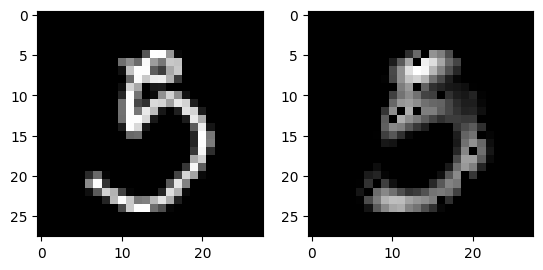

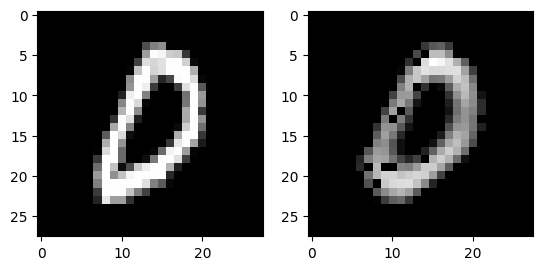

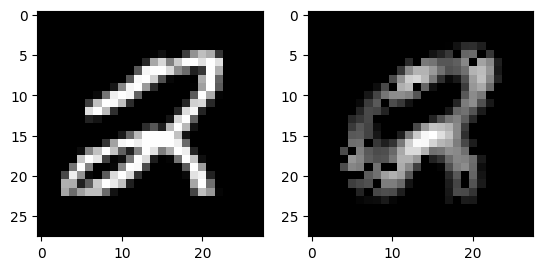

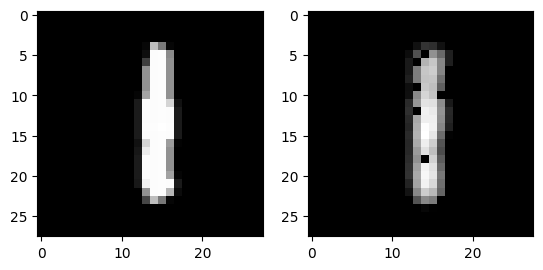

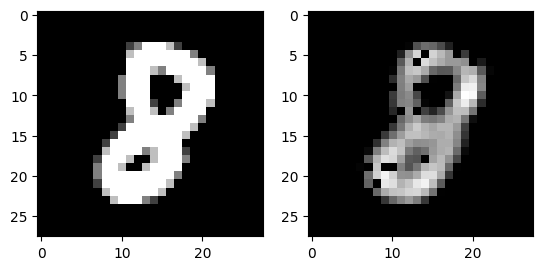

In [17]:
import matplotlib.pyplot as plt

out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(input[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()